## **Practical No: 6**

### **AIM:** Build a recommendation engine Boltzmann machines for the entertainment sector.

### **CODE and OUTPUT**

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [2]:
# Load the data
ratingDF = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/rating.csv")

In [3]:
# Convert fields into appropriate data types
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = pd.to_datetime(ratingDF.timestamp)

In [4]:
# Preview data
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
# Calculate summary statistics on full dataset

# 20,000,263 ratings
# 26,744 unique movies
# 138,493 unique users
# 144 ratings on average per user

n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


In [6]:
# Reduce size of dataset by taking top 1000 movies
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
                "rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [7]:
# Reduce size of dataset by sampling 1000 users
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
    "rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

In [8]:
# Reindex movie ID
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1
moviesDF.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


In [9]:
# Reindex user ID
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1
usersDF.head()

,originalUserId,newUserId
0,49,1
1,260,2
2,311,3
3,319,4
4,499,5


In [10]:
# Generate newly merged DataFrame
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId', \
                              right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)

ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', \
                              right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1


In [11]:
# Calculate summary statistics on reduced dataset
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


In [12]:
# Split into validation and test, such that each is 5% of the dataset
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, \
                                   shuffle=True, random_state=2018)

X_validation, X_test = train_test_split(X_test, test_size=0.50, \
                                        shuffle=True, random_state=2018)

In [13]:
# Confirm size of train, validation, and test datasets
print('Size of train set: ', len(X_train))
print('Size of validation set: ', len(X_validation))
print('Size of test set: ', len(X_test))

Size of train set:  81191
Size of validation set:  4511
Size of test set:  4511


In [14]:
# Generate ratings matrix for train
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [15]:
ratings_train.shape

(1000, 1000)

In [16]:
# Calculate sparsity of the train ratings matrix
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 8.12%


In [17]:
# Generate ratings matrix for validation
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [18]:
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

In [19]:
# Calculate sparsity of the validation ratings matrix
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.45%


In [20]:
# Experiment one - Assign naive 3.5 rating and calculate baseline MSE

actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5

naive_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using naive prediction:', naive_prediction)

Mean squared error using naive prediction: 1.055420084238528


In [21]:
# Experiment two - Predict a user's rating based on user's average rating 
# for all other movies

ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 0.9090717929472647


In [22]:
# Experiment three - Predict a user's rating for a movie based on the
# average rating other users have given that movie

ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using movie average:', movie_average)

Mean squared error using movie average: 0.9136057106858655


In [23]:
# Experiment four - Recommender System using Matrix Factorization
# 1 Latent Factor

n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [24]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 6s 2ms/step - loss: 13.3814 - val_loss: 11.4075
Epoch 2/100
2538/2538 [==============================] - 7s 3ms/step - loss: 8.6914 - val_loss: 6.1696
Epoch 3/100
2538/2538 [==============================] - 5s 2ms/step - loss: 4.4006 - val_loss: 3.2031
Epoch 4/100
2538/2538 [==============================] - 5s 2ms/step - loss: 2.4570 - val_loss: 1.9912
Epoch 5/100
2538/2538 [==============================] - 5s 2ms/step - loss: 1.6014 - val_loss: 1.4118
Epoch 6/100
2538/2538 [==============================] - 5s 2ms/step - loss: 1.1761 - val_loss: 1.1216
Epoch 7/100
2538/2538 [==============================] - 5s 2ms/step - loss: 0.9613 - val_loss: 0.9695
Epoch 8/100
2538/2538 [==============================] - 5s 2ms/step - loss: 0.8514 - val_loss: 0.8913
Epoch 9/100
2538/2538 [==============================] - 5s 2ms/step - loss: 0.7941 - val_loss: 0.8489
Epoch 10/100
2538/2538 [==============================] - 5s 2ms/step -

Minimum MSE:  0.7954029440879822


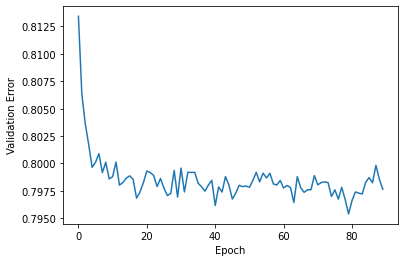

In [25]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [26]:
# Experiment five - Recommender System using Matrix Factorization
# 3 Latent Factors

n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           embeddings_regularizer=regularizers.l1(10e-7), \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors, \
                            embeddings_regularizer=regularizers.l1(10e-7), \
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [27]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 7s 2ms/step - loss: 11.8470 - val_loss: 7.3148
Epoch 2/100
2538/2538 [==============================] - 6s 2ms/step - loss: 4.1904 - val_loss: 2.4498
Epoch 3/100
2538/2538 [==============================] - 6s 2ms/step - loss: 1.7305 - val_loss: 1.3423
Epoch 4/100
2538/2538 [==============================] - 6s 2ms/step - loss: 1.0686 - val_loss: 0.9897
Epoch 5/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.8541 - val_loss: 0.8728
Epoch 6/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.7826 - val_loss: 0.8291
Epoch 7/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.7575 - val_loss: 0.8149
Epoch 8/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.7487 - val_loss: 0.8127
Epoch 9/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.7453 - val_loss: 0.8096
Epoch 10/100
2538/2538 [==============================] - 6s 2ms/step - 

Minimum MSE:  0.773015558719635


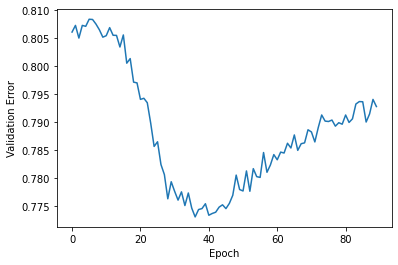

In [28]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [29]:
# Experiment six - Recommender System using Matrix Factorization
# 5 Latent Factors

n_latent_factors = 5

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           embeddings_regularizer=regularizers.l1(10e-7), \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors, \
                            embeddings_regularizer=regularizers.l1(10e-7), \
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [30]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 9s 3ms/step - loss: 10.8360 - val_loss: 5.1245
Epoch 2/100
2538/2538 [==============================] - 6s 2ms/step - loss: 2.7953 - val_loss: 1.6655
Epoch 3/100
2538/2538 [==============================] - 6s 2ms/step - loss: 1.2109 - val_loss: 1.0290
Epoch 4/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.8681 - val_loss: 0.8664
Epoch 5/100
2538/2538 [==============================] - 7s 3ms/step - loss: 0.7818 - val_loss: 0.8252
Epoch 6/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.7593 - val_loss: 0.8151
Epoch 7/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.7524 - val_loss: 0.8163
Epoch 8/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.7505 - val_loss: 0.8162
Epoch 9/100
2538/2538 [==============================] - 6s 2ms/step - loss: 0.7499 - val_loss: 0.8121
Epoch 10/100
2538/2538 [==============================] - 7s 3ms/step - 

Minimum MSE:  0.7632550597190857


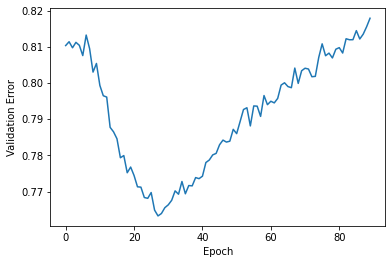

In [31]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [32]:
# Experiment seven - Recommender System using RBMs

# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

In [33]:
# Begin the training cycle

# Convert inputX into float32
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,1000,1,1000,200)

In [34]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [35]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Instructions for updating:
Use `tf.cast` instead.


Epoch: 0 reconstruction error: 1.105672
Epoch: 1 reconstruction error: 1.086300
Epoch: 2 reconstruction error: 1.088289
Epoch: 3 reconstruction error: 1.091463
Epoch: 4 reconstruction error: 1.094885
Epoch: 5 reconstruction error: 1.089568
Epoch: 6 reconstruction error: 1.087010
Epoch: 7 reconstruction error: 1.084026
Epoch: 8 reconstruction error: 1.090812
Epoch: 9 reconstruction error: 1.090773
Epoch: 10 reconstruction error: 1.087659
Epoch: 11 reconstruction error: 1.088191
Epoch: 12 reconstruction error: 1.090932
Epoch: 13 reconstruction error: 1.092173
Epoch: 14 reconstruction error: 1.086355
Epoch: 15 reconstruction error: 1.098410
Epoch: 16 reconstruction error: 1.083730
Epoch: 17 reconstruction error: 1.098915
Epoch: 18 reconstruction error: 1.090055
Epoch: 19 reconstruction error: 1.092463
Epoch: 20 reconstruction error: 1.092366
Epoch: 21 reconstruction error: 1.093835
Epoch: 22 reconstruction error: 1.094741
Epoch: 23 reconstruction error: 1.095029
Epoch: 24 reconstruction e

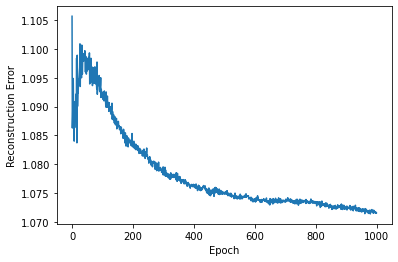

In [36]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error");

In [37]:
# Predict ratings for validation set
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)

finalOutput_validation, reconstructedOutput_validation, _ = \
    rbm.rbm_output(inputValidation)

In [38]:
# Calculate MSE on validation set
predictionsArray = reconstructedOutput_validation
pred_validation = \
    predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = \
    ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 9.332243405009976
